## Machine Learning : Decision Tree for Classification

In this notebook we will implement a decision tree from scratch without using any inbuilt functions. The main goal here is to get the understanding of how decision tree calculations are done.

## Problem Statement
Build a decision tree model to predict the usage of car. The data is the claim_history.csv which has 10,302 observations. The analysis specifications are:

### Target Variable  
#### CAR_USE
The usage of a car. This variable has two categories which are Commercial and Private. The Commercial category is the Event value.

### Nominal Predictor 
#### CAR_TYPE. 
The type of a car. This variable has six categories which are Minivan, Panel Truck, Pickup, SUV, Sports Car, and Van.
#### OCCUPATION. 
The occupation of the car owner. This variable has nine categories which are Blue Collar, Clerical, Doctor, Home Maker, Lawyer, Manager, Professional, Student, and Unknown.

### Ordinal Predictor
#### EDUCATION. 
The education level of the car owner. This variable has five ordered categories which are Below High School < High School < Bachelors < Masters < Doctors. 

### Analysis Specifications

Partition. Specify the target variable as the stratum variable. Use stratified simple random sampling to put 70% of the records into the Training partition, and the remaining 30% of the records into the Test partition. The random state is 27513.

### Decision Tree. 
The maximum number of branches is two. The maximum depth is two. The split criterion is the *Entropy* metric.

### Import numpy to speed up the mathematical calculations and pandas to manipulate the data using dataframes.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

from sklearn import metrics

from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

### Load Dataset

In [2]:
df = pd.read_csv("/kaggle/input/claim_history.csv")
df.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,TIF,CAR_TYPE,RED_CAR,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,URBANICITY,CLM_COUNT,EXPOSURE
0,63581743,0,16-Mar-39,60.0,0,11.0,67000.0,No,NaN,No,...,11,Minivan,yes,No,3,0,18.0,Highly Urban/ Urban,0,0.189
1,132761049,0,21-Jan-56,43.0,0,11.0,91000.0,No,257000.0,No,...,1,Minivan,yes,No,0,0,1.0,Highly Urban/ Urban,0,1.000
2,921317019,0,18-Nov-51,48.0,0,11.0,53000.0,No,NaN,No,...,1,Van,yes,No,2,0,10.0,Highly Urban/ Urban,0,1.000
3,727598473,0,5-Mar-64,35.0,1,10.0,16000.0,No,124000.0,Yes,...,4,SUV,no,No,3,0,10.0,Highly Urban/ Urban,0,0.828
4,450221861,0,5-Jun-48,51.0,0,14.0,NaN,No,306000.0,Yes,...,7,Minivan,yes,No,0,0,6.0,Highly Urban/ Urban,0,0.729


### Train Test Split
Divide our data into training and testing sets. Features are the independent varibles (predictors). Labels are the dependent variables (Target). 

In [3]:
from sklearn.model_selection import train_test_split
features = df[["CAR_TYPE","OCCUPATION","EDUCATION"]]
features.head()

,CAR_TYPE,OCCUPATION,EDUCATION
0,Minivan,Professional,Doctors
1,Minivan,Blue Collar,High School
2,Van,Manager,Bachelors
3,SUV,Clerical,High School
4,Minivan,Blue Collar,Below High School


In [4]:
#Split for training and testing data
features_train,features_test,labels_train, labels_test = train_test_split(features,df["CAR_USE"],test_size = 0.3, random_state=27513,stratify = df["CAR_USE"])

### Frequency Table
Frequency tables give the proportion of Commercial and Private car use in the given data. It will be required for entropy calculations discussed below. 
Give the frequency table of the target variable (CAR_USE) in training partition.

In [5]:
cross_Table_Train = pd.crosstab(labels_train,columns =  ["Count"],margins=True,dropna=True)
cross_Table_Train["Proportions"] = (cross_Table_Train["Count"]/len(labels_train))*100
cross_Table_Train

col_0,Count,All,Proportions
CAR_USE,,,
Commercial,2652,2652,36.777146
Private,4559,4559,63.222854
All,7211,7211,100.000000


Give the frequency table of the target variable (CAR_USE) in Testing partition?

In [6]:
cross_Table_test = pd.crosstab(labels_test,columns =  ["Count"],margins=True,dropna=True)
cross_Table_test["Proportions"] = (cross_Table_test["Count"]/len(labels_test))*100
cross_Table_test

col_0,Count,All,Proportions
CAR_USE,,,
Commercial,1137,1137,36.784212
Private,1954,1954,63.215788
All,3091,3091,100.000000


It can be observed that the data is distributed in equal proportions in both training and testing sets. This stratification will help in testing the model that we will generate as it will have equal proportions of Commercial and Private observations.

### Conditional Probability
What is the probability that an observation is in the Training partition given that CAR_USE = Commercial?
#### P ( Train | Car Use = Commercial )


In [7]:
c=0
prob_train = len(features_train)/len(df["CAR_USE"]) #Probability of the observation in Training set
for i in df["CAR_USE"]:
    if i =="Commercial":
        c+=1        #Probability of the observation being Commercial
(prob_train*c/len(df["CAR_USE"]))/(c/len(df["CAR_USE"]))   #Probability that observation is in the Training partition given that CAR_USE = Commercial
print("The probability that an observation is in the Training partition given that CAR_USE = Commercial is",(prob_train*c/10302)/(c/10302))

The probability that an observation is in the Training partition given that CAR_USE = Commercial is 0.6999611725878471


What is the probability that an observation is in the Test partition given that CAR_USE = Private?

#### P ( Test | Car Use = Private )

In [8]:
count=0
prob_test = len(features_test)/len(df["CAR_USE"]) #Probability of the observation in Testing set
for i in df["CAR_USE"]:
    if i =="Private":
        count+=1        #Probability of the observation being Private
(prob_test*count/10302)/(count/10302)   #Probability that observation is in the Testing partition given that CAR_USE = Private

print("The probability that an observation is in the Testing partition given that CAR_USE = Private is",(prob_test*count/10302)/(count/10302))

The probability that an observation is in the Testing partition given that CAR_USE = Private is 0.300038827412153


In [9]:
features_train["Labels"] = labels_train

### Entropy
The goal of building a Decision Tree is to subdivide the data by predictors in such a way that the target values for the observations in the terminal nodes are as similar as possible. Meaning, the terminal nodes must have maximum number of observations belonging to the same class. 
One criteria to do that is to calculate the entropy value.

#### *Entropy*
  Entropy is the measure of the impurity of the split. Higher the entropy value, more impure is the split. Hence, the best split is the one which has lowest entropy value. The entropy values lie between 0 to 1. The entropy calculations are discussed over the link [here.][1]

[1]: https://www.saedsayad.com/decision_tree.htm

### Entropy of Root node
Here, we calculate the entropy of root node. To calculate the entropy of root node, we calculate the probability for Commercial and Private Car_Use in the given dataframe. By substituting these values in the entropy formula, we find the entropy of root node.   

In [10]:
#Entropy of Root Node
cnt = 0
for i in df["CAR_USE"]:
    if i == "Commercial":
        cnt+=1
proba_commercial = cnt/len(df["CAR_USE"])

proba_private = (len(df["CAR_USE"])-cnt)/len(df["CAR_USE"])

ans = -((proba_commercial * np.log2(proba_commercial) + proba_private * np.log2(proba_private)))
print("Entropy for root node is given as",ans)

Entropy for root node is given as 0.9489621493401781


### Finding best splits

### Steps
1.Start with the first predictor, select a value to split data in the node into two partitions.
   Interval or Ordinal Predictors: {x: x < a} and {x: x  a} where a is a value
   Nominal Predictor: {x: x belongs to A} and {x: x belongs to A} where A is a subset of values
   
2.Apply the Goodness of Split Criterion, calculate the impurity of the partitions, and evaluate the reduction of impurity from the parent node.

3.Select the split partition that results in the largest reduction of impurity and labels it the “best” split for the predictor.

4.Repeat steps 1 to 3 for each remaining predictors.  Go to step 5 when “best” splits are found for all predictors.

5.Ranks all of the “best” split of each predictor according to the reduction in impurity achieved by each split.

6.Select the predictor and its split partition that most reduced impurity of the parent node.

7.Assign observations to one of the two child nodes.

8.Determine whether the child nodes are terminal based on the Stopping Criteria (Here it is when we reach at level 2)

9.Repeat steps 1 to 8 for each non-terminal child nodes.

To find the best splits, we will have to take each predictor in consideration. For each predictor, we find all possible combinations that the predictor has. By doing this, we can frame proper question to be asked at each split. So, we will do this for the first level. We will take all three predictors in consideration and find the best split amongst all three. Then from those three best splits, we will select one split based on the minimum entropy value. This will be question we will ask at level 1.

For example, we have a predictor which has values A,B,C,D. The possible combinations for this predictor would be (A)(B)(C)(D)(A,B)(A,C)(A,D)(B,C)(B,D)(C,D). These tuples that we see are the possible questions that we can frame while splitting the data. It can be like, whether the predictor belongs to class A. If yes, the it will be splitted at the left node, or it will be belonging to B,C or D, which will end up at right node. According to this split, the entropy value will be calculated based upon the target variable proportions. If the entropy value is less, it can be considered as the best split.

We will try the above steps for each of the predictors and find the best split.

### Possible combinations for each predictor [Occupation, Car_type, Education]

In [11]:
#All possible combinations for occupation
occupation_column = df["OCCUPATION"].unique()
occupation_combinations = []
for i in range(1,math.ceil(len(occupation_column)/2)):
    occupation_combinations+=list(combinations(occupation_column,i))

In [12]:
#All possible combinations for car type
car_type_column = df["CAR_TYPE"].unique()
car_type_combinations = []

for i in range(1,math.ceil(len(car_type_column)/2)+1):
    x = list(combinations(car_type_column,i))
    if i == 3:
        x = x[:10]
    car_type_combinations.extend(x) 

In [13]:
#All possible combinations for education
education_combinations = [("Below High School",),("Below High School","High School",),("Below High School","High School","Bachelors",),("Below High School","High School","Bachelors","Masters",)]

### Entropy Calculation for a single split in the given predictor
Here we define a function which returns the entropy of the given split. It takes the predictor and corresponding target values as the first input. The second input is the split on which we need to calculate the entropy on. For example we take occupation as the predictor and the split for it will be something like ('Blue Collar', 'Manager', 'Student'), i.e we will split our observations based on this tuple. Then after splitting, we calculate frequency table to get the proportion of target variables in each split. Using this, we can calculate the entropy which will be returned by this function.

In [14]:
def EntropyIntervalSplit (
   inData,          # input data frame (predictor in column 0 and target in column 1)
   split):          # split value

   #print(split)
   dataTable = inData
   dataTable['LE_Split'] = False
   for k in dataTable.index:
       if dataTable.iloc[:,0][k] in split:
           dataTable['LE_Split'][k] = True
   #print(dataTable['LE_Split'])
   crossTable = pd.crosstab(index = dataTable['LE_Split'], columns = dataTable.iloc[:,1], margins = True, dropna = True)   
   #print(crossTable)

   nRows = crossTable.shape[0]
   nColumns = crossTable.shape[1]
   
   tableEntropy = 0
   for iRow in range(nRows-1):
      rowEntropy = 0
      for iColumn in range(nColumns):
         proportion = crossTable.iloc[iRow,iColumn] / crossTable.iloc[iRow,(nColumns-1)]
         if (proportion > 0):
            rowEntropy -= proportion * np.log2(proportion)
      #print('Row = ', iRow, 'Entropy =', rowEntropy)
      #print(' ')
      tableEntropy += rowEntropy *  crossTable.iloc[iRow,(nColumns-1)]
   tableEntropy = tableEntropy /  crossTable.iloc[(nRows-1),(nColumns-1)]
  
   return(tableEntropy)

### Function to find minimum entropy split in each predictor
In the above function, we calculated the entropy for just one single split. Now the function below takes all such possible splits, calculate entropy of ech split and return the minimum entropy split. By this, we get the best split for the given predictor. We use this function for each predictor to get best entropies of each predictor. 

In [15]:
def calculate_min_entropy(df,variable,combinations):
    inData1 = df[[variable,"Labels"]]
    entropies = []
    for i in combinations:
        EV = EntropyIntervalSplit(inData1, list(i))
        entropies.append((EV,i))
    return min(entropies)

Entropy for best split in Occupation

In [16]:
entropy_occupation = calculate_min_entropy(features_train,"OCCUPATION",occupation_combinations)
entropy_occupation

(0.7148805225259208, ('Blue Collar', 'Unknown', 'Student'))

Entropy for best split in Car Type

In [17]:
entropy_cartype = calculate_min_entropy(features_train,"CAR_TYPE",car_type_combinations)
entropy_cartype

(0.7573352263531922, ('Minivan', 'SUV', 'Sports Car'))

Entropy for best split in EDUCATION

In [18]:
entropy_education = calculate_min_entropy(features_train,"EDUCATION",education_combinations)
entropy_education

(0.9343298080392602, ('Below High School',))

From the numbers above, it can be observed that the predcitor that can be used at level 1 is
### Occupation : Entropy Value 0.71488
It has the minimum entropy for the split ('Blue Collar', 'Unknown', 'Student') and the entropy value is 0.71488

Split the dataframes according to the given split. If the observation belongs to ('Blue Collar', 'Unknown', 'Student'), then it will be in the left dataframe, else it will be in the right dataframe. In this way, we create a parent node where we ask question about the occupation and split our data into two child nodes. Here, we are done with level 1.

In [19]:
df_1_left = features_train[(features_train["OCCUPATION"] == "Blue Collar") | (features_train["OCCUPATION"] == "Unknown") | (features_train["OCCUPATION"] == "Student")]
df_1_right =  features_train[(features_train["OCCUPATION"] != "Blue Collar") & (features_train["OCCUPATION"] != "Unknown") & (features_train["OCCUPATION"] != "Student")]
len(df_1_right),len(df_1_left)

(4543, 2668)

Now we repeat the same process of entropy calculation on each sub-dataframe we created. We will find best split at each node again and get done with level 2.

### Entropy Calculations for left split

In [20]:
left_edu_entropy = calculate_min_entropy(df_1_left,"EDUCATION",education_combinations)
left_edu_entropy

(0.6505878239994441, ('Below High School',))

In [21]:
left_ct_entropy = calculate_min_entropy(df_1_left,"CAR_TYPE",car_type_combinations)
left_ct_entropy

(0.7689481386570244, ('Minivan', 'SUV', 'Sports Car'))

In [22]:
occupation_column = ['Blue Collar', 'Unknown', 'Student']
occupation_combinations = []
for i in range(1,math.ceil(len(occupation_column)/2)):
    occupation_combinations+=list(combinations(occupation_column,i))
left_occupation_entropy = calculate_min_entropy(df_1_left,"OCCUPATION",occupation_combinations)
occupation_combinations

[('Blue Collar',), ('Unknown',), ('Student',)]

### Entropy calculations for right split

In [23]:
occupation_column = ['Professional', 'Manager', 'Clerical', 'Doctor','Lawyer','Home Maker']
occupation_combinations = []
for i in range(1,math.ceil(len(occupation_column)/2)):
    occupation_combinations+=list(combinations(occupation_column,i))
right_occupation_entropy = calculate_min_entropy(df_1_right,"OCCUPATION",occupation_combinations)

right_edu_entropy = calculate_min_entropy(df_1_right,"EDUCATION",education_combinations)
right_ct_entropy = calculate_min_entropy(df_1_right,"CAR_TYPE",car_type_combinations)
right_ct_entropy , right_edu_entropy , right_occupation_entropy

((0.3212873372854656, ('Minivan', 'SUV', 'Sports Car')),
 (0.623532570928089, ('Below High School', 'High School', 'Bachelors')),
 (0.5740628685071641, ('Doctor', 'Lawyer')))

The best split with minimum entropy that we get is on Car type for the left node at level 1
(0.7689481386570244, ('Minivan', 'SUV', 'Sports Car')).

In [24]:
df_2_left_left = df_1_left[(features_train["EDUCATION"] == "Below High School")]
df_2_left_right = df_1_left[(features_train["EDUCATION"] != "Below High School")]

Now, we have reached the second level of the tree. We have four leaf nodes into which our data is splitted. Let "Commercial" be the event and "Private" be non-event. From the leaf node data, we will find the probability of event at that particular node. We do this by taking the proportion of count of "Commercial" observations to the total observations. We do this for each leaf node.

Once we have these probability, we will use it to make predictions.


In [25]:
cnt = 0
for i in df_2_left_left["Labels"]:
    if i == "Commercial":
        cnt+=1
proba_commercial = cnt/len(df_2_left_left["Labels"])
print("Count of commercial and private is",cnt,(len(df_2_left_left)-cnt),"respectively and probability of the event",proba_commercial)

Count of commercial and private is 140 428 respectively and probability of the event 0.24647887323943662


In [26]:
cnt = 0
for i in df_2_left_right["Labels"]:
    if i == "Commercial":
        cnt+=1
proba_commercial = cnt/len(df_2_left_right["Labels"])
print("Count of commercial and private is",cnt,(len(df_2_left_right)-cnt),"respectively and probability of the event",proba_commercial)

Count of commercial and private is 1786 314 respectively and probability of the event 0.8504761904761905


In [27]:
df_2_right_left = df_1_right[(features_train["CAR_TYPE"] == "Minivan") | (features_train["CAR_TYPE"] == "Sports Car") | (features_train["CAR_TYPE"] == "SUV")]
df_2_right_right = df_1_right[(features_train["CAR_TYPE"] != "Minivan") & (features_train["CAR_TYPE"] != "Sports Car") & (features_train["CAR_TYPE"] != "SUV")]

In [28]:
cnt = 0
for i in df_2_right_left["Labels"]:
    if i == "Commercial":
        cnt+=1
proba_commercial = cnt/len(df_2_right_left["Labels"])
1-proba_commercial
print("Count of commercial and private is",cnt,(len(df_2_right_left)-cnt),"respectively and probability of the event",proba_commercial)

Count of commercial and private is 20 3231 respectively and probability of the event 0.006151953245155337


In [29]:
cnt = 0
for i in df_2_right_right["Labels"]:
    if i == "Commercial":
        cnt+=1
proba_commercial = cnt/len(df_2_right_right["Labels"])
proba_commercial
print("Count of commercial and private is",cnt,(len(df_2_right_right)-cnt),"respectively and probability of the event",proba_commercial)

Count of commercial and private is 706 586 respectively and probability of the event 0.5464396284829721


As we have the probabilites of event for each node ready, we calculate the threshold against which it can be compared. For this example, we will calculate threshold by taking the proportion of target Event value in the training dataset.

In [30]:
#Thresold probability of the event from training set
cnt = 0
for i in features_train["Labels"]:
    if i == "Commercial":
        cnt+=1
threshold = cnt/len(features_train["Labels"])
print("Threshold probability of an event is given as",threshold)

Threshold probability of an event is given as 0.3677714602690334


### Decision Rules
Now that we have all the numbers, we define decision rules by which the model will predict the class of an observation. We use the probability of each node and thresold probability to define the set of rules. First of all, get the list of predicted probabilty for each observation that we wish to classify. We use our testing dataset to do so.

In [31]:
predicted_probability=[]
occ = ["Blue Collar","Student","Unknown"]
edu = ["Below High School",]
cartype = ["Minivan","SUV","Sports Car"]
for k in features_test.index:
    if features_test.iloc[:,1][k] in occ:
            if features_test.iloc[:,2][k] in edu:
                predicted_probability.append(0.24647887323943662)  #Leftmost Leaf Node
            else:
                predicted_probability.append(0.8504761904761905)   #Right leaf from left subtree
    else:
            if features_test.iloc[:,0][k] in cartype:
                predicted_probability.append(0.006151953245155337)  #Left leaf from right subtree
            else:
                predicted_probability.append(0.5464396284829721)   #Rightmost Leaf Node

Once we have the list of predicted probabilities, we use the threshold to compare and predict the class of the observation. If the predicted probability is greater than or equal to threshold, classify it as a event (Commercial), else non-event (Private). 

In [32]:
prediction = []
for i in range(0,len(labels_test)):
    if predicted_probability[i] >= threshold :
        prediction.append("Commercial")
    else:
        prediction.append("Private")

### Misclassification Rate
To see how well the model is behaving, calculate the misclassification rate. Misclassification rate is defined as percentage of the observations from the dataset misclassified. Lower this rate, more accurate the model is. We have our predictions for the observations in testing data and their original classes too. Use it to find the misclassification rate.

In [33]:
from sklearn.metrics import accuracy_score
print("Missclassification Rate",1-accuracy_score(labels_test,prediction))

Missclassification Rate 0.1708185053380783


### Root Average Squared Error

In [34]:
RASError = 0.0
for i in range (0,len(labels_test)):
    if labels_test.iloc[i] == "Commercial":
        RASError += (1-predicted_probability[i])**2
    else:
        RASError += (predicted_probability[i])**2
RASError = math.sqrt(RASError/len(labels_test))
RASError

0.3300251195213117

### Area under the curve

In [35]:
true_values = 1.0 * np.isin(labels_test, ['Commercial'])
AUC = metrics.roc_auc_score(true_values, predicted_probability)
AUC

0.9114708659772841

Few metrics to see how the model is behaving

In [36]:
print("Root Average Squared Error",RASError)
print("Area Under the curve",AUC)
print("Missclassification Rate",1-accuracy_score(labels_test,prediction))

Root Average Squared Error 0.3300251195213117
Area Under the curve 0.9114708659772841
Missclassification Rate 0.1708185053380783


In [37]:
OneMinusSpecificity, Sensitivity, thresholds = metrics.roc_curve(labels_test, predicted_probability, pos_label = 'Commercial')

In [38]:
OneMinusSpecificity = np.append([0], OneMinusSpecificity)
Sensitivity = np.append([0], Sensitivity)

OneMinusSpecificity = np.append(OneMinusSpecificity, [1])
Sensitivity = np.append(Sensitivity, [1])

### Receiver Operating Characteristic

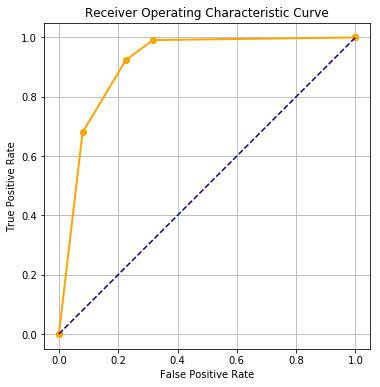

In [39]:
plt.figure(figsize=(6,6))
plt.plot(OneMinusSpecificity, Sensitivity, marker = 'o',
         color = 'orange', linestyle = 'solid', linewidth = 2, markersize = 6)
plt.plot([0, 1], [0, 1], color = 'darkblue', linestyle = '--')
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

### Conclusion 
We build a decision tree for classifying the data into two different classes based on three predictors. The decision tree has two levels, four leaf nodes at which the decision is made. We used entropy values to find the best split at each node. To test how the model is performing, we used various evaluation metrics like misclassification rate and area under the curve. By looking at those numbers, we can say that the model is performing decently.  